In [2]:
# =======================
# IMPORTS
# =======================
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, GlobalAveragePooling2D, LeakyReLU, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2, EfficientNetB0, ResNet50, VGG16
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve, auc
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import random

In [3]:
# =======================
# CONFIGURATIONS
# =======================
IMG_SIZE = 224
BATCH_SIZE = 16
EPOCHS = 20
TFLITE_PATH = "model.tflite"
SEED = 42
LOSS_FUNCTION = 'binary_crossentropy'
ARCHITECTURE = 'CNN'
ACTIVATION = 'leaky_relu'
OPTIMIZER = 'adamw'
THRESHOLD = 0.4
FINE_TUNE = True
FINE_TUNE_EPOCHS = 5
FINE_TUNE_LEARNING_RATE = 1e-5

tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)
train_path = r"C:\\Users\\Adars\\Desktop\\dataset\\train"
test_path = r"C:\\Users\\Adars\\Desktop\\dataset\\test"

In [4]:
# =======================
# FUNCTIONS
# =======================
def focal_loss(gamma=2.0, alpha=0.25):
    def focal_loss_fn(y_true, y_pred):
        epsilon = K.epsilon()
        y_pred = K.clip(y_pred, epsilon, 1.0 - epsilon)
        p_t = tf.where(K.equal(y_true, 1), y_pred, 1 - y_pred)
        alpha_factor = K.ones_like(y_true) * alpha
        alpha_factor = tf.where(K.equal(y_true, 1), alpha_factor, 1 - alpha_factor)
        cross_entropy = -K.log(p_t)
        loss = alpha_factor * K.pow(1 - p_t, gamma) * cross_entropy
        return K.mean(K.sum(loss, axis=-1))
    return focal_loss_fn

def get_activation_function(name):
    if name == 'relu': return tf.keras.layers.ReLU()
    elif name == 'leaky_relu': return LeakyReLU(alpha=0.3)
    elif name == 'elu': return tf.keras.layers.ELU()
    else: return tf.keras.layers.ReLU()

def get_optimizer(name):
    if name == 'adam': return tf.keras.optimizers.Adam(learning_rate=1e-4)
    elif name == 'adamw': return tf.keras.optimizers.AdamW(learning_rate=1e-4)
    elif name == 'sgd': return tf.keras.optimizers.SGD(learning_rate=1e-4, momentum=0.7)
    elif name == 'rmsprop': return tf.keras.optimizers.RMSprop(learning_rate=1e-4)
    else: return tf.keras.optimizers.Adam(learning_rate=1e-4)

In [5]:
# =======================
# MODEL BUILDING
# =======================
def build_model(architecture, activation_fn):
    if architecture == 'MobileNetV2':
        base_model = MobileNetV2(input_shape=(IMG_SIZE, IMG_SIZE, 3), include_top=False, weights='imagenet')
    elif architecture == 'EfficientNetB0':
        base_model = EfficientNetB0(input_shape=(IMG_SIZE, IMG_SIZE, 3), include_top=False, weights='imagenet')
    elif architecture == 'ResNet50':
        base_model = ResNet50(input_shape=(IMG_SIZE, IMG_SIZE, 3), include_top=False, weights='imagenet')
    elif architecture == 'VGG16':
        base_model = VGG16(input_shape=(IMG_SIZE, IMG_SIZE, 3), include_top=False, weights='imagenet')
    elif architecture == 'CNN':
        model = Sequential([
            Conv2D(32, (3,3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
            MaxPooling2D(2,2),
            Conv2D(64, (3,3), activation='relu'),
            MaxPooling2D(2,2),
            Conv2D(128, (3,3), activation='relu'),
            MaxPooling2D(2,2),
            Flatten(),
            Dense(256),
            activation_fn,
            Dropout(0.5),
            Dense(1, activation='sigmoid')
        ])
        return model
    else:
        raise ValueError(f"Invalid architecture: {architecture}")

    base_model.trainable = False
    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        model.add(tf.keras.layers.LayerNormalization()),
        Dense(256),
        activation_fn,
        BatchNormalization(),
        Dropout(0.6),
        Dense(128),    # Additional layer
        activation_fn,
        BatchNormalization(),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    return model

In [6]:
# =======================
# DATA GENERATORS
# =======================
def create_data_generators():
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=30,
        zoom_range=0.3,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.2,    
        fill_mode='nearest',
        horizontal_flip=True,
        vertical_flip=True,
        validation_split=0.2
    )
    test_datagen = ImageDataGenerator(rescale=1./255)
    train_gen = train_datagen.flow_from_directory(
        train_path,
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='binary',
        subset='training',
        seed=SEED
    )
    val_gen = train_datagen.flow_from_directory(
        train_path,
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='binary',
        subset='validation',
        seed=SEED
    )
    test_gen = test_datagen.flow_from_directory(
        test_path,
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='binary',
        shuffle=False
    )
    return train_gen, val_gen, test_gen

Found 7368 images belonging to 2 classes.
Found 1842 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


c:\Users\Adars\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
c:\Users\Adars\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Class Weights: {0: np.float64(1.0), 1: np.float64(1.0)}


c:\Users\Adars\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
461/461 ━━━━━━━━━━━━━━━━━━━━ 539s 1s/step - accuracy: 0.7243 - loss: 0.5124 - precision: 0.7060 - recall: 0.8117 - val_accuracy: 0.8751 - val_loss: 0.3237 - val_precision: 0.8424 - val_recall: 0.8936 - learning_rate: 1.0000e-04
Epoch 2/20
461/461 ━━━━━━━━━━━━━━━━━━━━ 441s 955ms/step - accuracy: 0.8556 - loss: 0.3416 - precision: 0.8382 - recall: 0.8708 - val_accuracy: 0.8844 - val_loss: 0.2905 - val_precision: 0.8859 - val_recall: 0.8849 - learning_rate: 1.0000e-04
Epoch 3/20
461/461 ━━━━━━━━━━━━━━━━━━━━ 197s 428ms/step - accuracy: 0.8719 - loss: 0.3151 - precision: 0.8463 - recall: 0.8803 - val_accuracy: 0.8762 - val_loss: 0.3055 - val_precision: 0.8507 - val_recall: 0.9034 - learning_rate: 1.0000e-04
Epoch 4/20
461/461 ━━━━━━━━━━━━━━━━━━━━ 199s 431ms/step - accuracy: 0.8733 - loss: 0.2951 - precision: 0.8526 - recall: 0.8790 - val_accuracy: 0.8626 - val_loss: 0.3684 - val_precision: 0.7869 - val_recall: 0.9023 - learning_rate: 1.0000e-04
Epoch 5/20
461/461 ━━━━━━━━━━━━━━━━

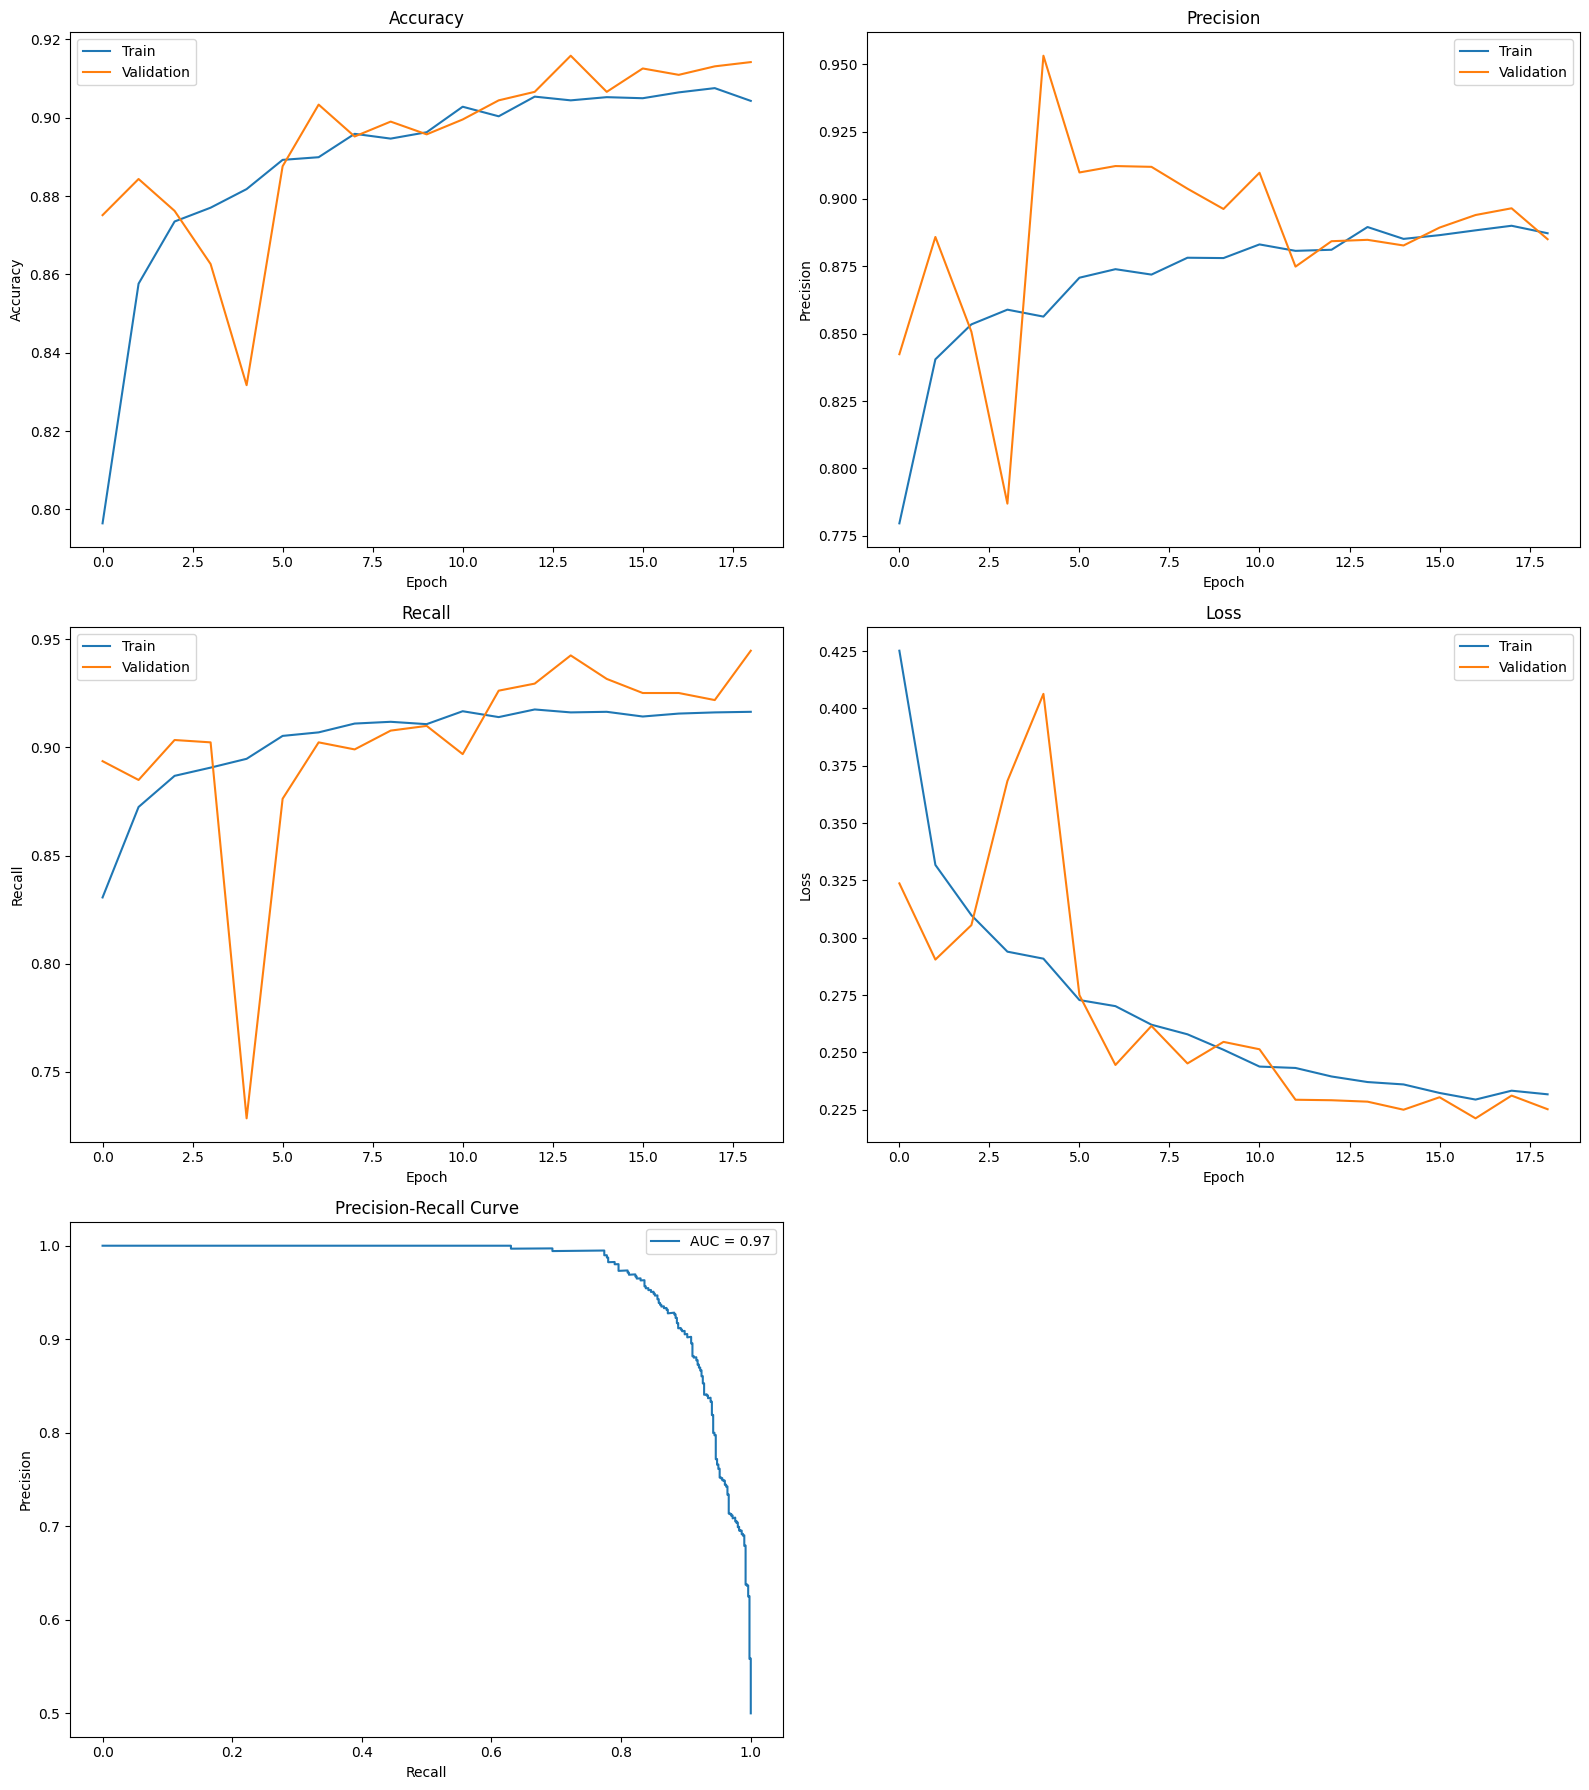

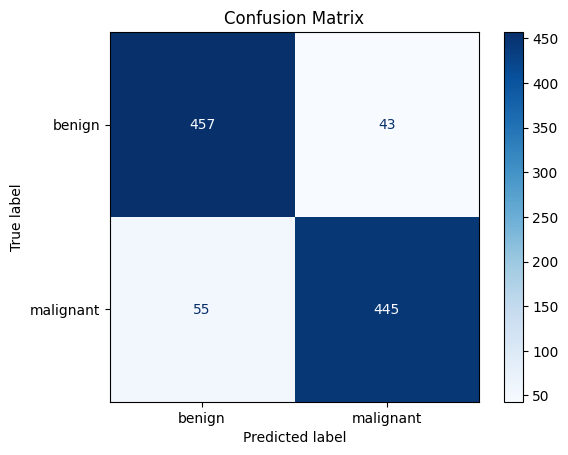

In [7]:
# =======================
# TRAINING & EVALUATION
# =======================
train_gen, val_gen, test_gen = create_data_generators()
model = build_model(ARCHITECTURE, get_activation_function(ACTIVATION))
loss = focal_loss() if LOSS_FUNCTION == 'focal' else 'binary_crossentropy'
custom_objects = {'focal_loss_fn': focal_loss(), 'LeakyReLU': LeakyReLU}
labels = train_gen.classes
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(labels), y=labels)
class_weight_dict = dict(enumerate(class_weights))
print(f"Class Weights: {class_weight_dict}")

model.compile(
    optimizer=get_optimizer(OPTIMIZER),
    loss=loss,
    metrics=['accuracy',
             tf.keras.metrics.Recall(name='recall', thresholds=THRESHOLD),
             tf.keras.metrics.Precision(name='precision', thresholds=THRESHOLD)]
)

callbacks = [
    EarlyStopping(monitor='val_accuracy', patience=5, mode='max', restore_best_weights=True),
    ModelCheckpoint('best_model.keras', save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)
]

history = model.fit(
        train_gen,
        epochs=EPOCHS,
        validation_data=val_gen,
        callbacks=callbacks,
        class_weight=class_weight_dict
    )

if FINE_TUNE and ARCHITECTURE != 'CNN':
    base_model = model.layers[0]
    base_model.trainable = True
    for layer in base_model.layers[:-20]:
        layer.trainable = False
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=FINE_TUNE_LEARNING_RATE),
        loss=loss,
        metrics=['accuracy',
                 tf.keras.metrics.Recall(name='recall', thresholds=THRESHOLD),
                 tf.keras.metrics.Precision(name='precision', thresholds=THRESHOLD)]
    )
    history_fine = model.fit(
        train_gen,
        epochs=EPOCHS + FINE_TUNE_EPOCHS,
        initial_epoch=history.epoch[-1] + 1,
        validation_data=val_gen,
        callbacks=callbacks,
        class_weight=class_weight_dict
    )
    for key in history.history.keys():
        history.history[key] += history_fine.history[key]

model = tf.keras.models.load_model('best_model.keras', custom_objects=custom_objects)

# Get final validation metrics
val_results = model.evaluate(val_gen)
print(f"\nValidation Metrics:")
print(f"Loss: {val_results[0]:.4f}")
print(f"Accuracy: {val_results[1]:.4f}")
print(f"Precision: {val_results[3]:.4f}")  # Note the index order
print(f"Recall: {val_results[2]:.4f}")

# Get test metrics
test_results = model.evaluate(test_gen)
print(f"\nTest Metrics:")
print(f"Loss: {test_results[0]:.4f}")
print(f"Accuracy: {test_results[1]:.4f}")
print(f"Precision: {test_results[3]:.4f}")
print(f"Recall: {test_results[2]:.4f}")

y_probs = model.predict(test_gen)
y_pred = (y_probs > THRESHOLD).astype(int)

plt.figure(figsize=(16, 18))
metrics = ['accuracy', 'precision', 'recall', 'loss']
titles = ['Accuracy', 'Precision', 'Recall', 'Loss']

for i, metric in enumerate(metrics):
    plt.subplot(3, 2, i + 1)
    plt.plot(history.history[metric], label='Train')
    plt.plot(history.history[f'val_{metric}'], label='Validation')
    plt.title(titles[i])
    plt.xlabel('Epoch')
    plt.ylabel(metric.capitalize())
    plt.legend()

plt.subplot(3, 2, 5)
precision, recall, _ = precision_recall_curve(test_gen.classes, y_probs)
plt.plot(recall, precision, label=f'AUC = {auc(recall, precision):.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()

plt.tight_layout()
plt.show()

cm = confusion_matrix(test_gen.classes, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=test_gen.class_indices.keys())
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix')
plt.show()

In [8]:
# ==================
# MODEL EXPORT
# ==================
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_types = [tf.float16]
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS]
tflite_model = converter.convert()
with open(TFLITE_PATH, 'wb') as f:
    f.write(tflite_model)
print(f"\nTFLite model saved to: {TFLITE_PATH}")

INFO:tensorflow:Assets written to: C:\Users\Adars\AppData\Local\Temp\tmpt6umq1kw\assets


INFO:tensorflow:Assets written to: C:\Users\Adars\AppData\Local\Temp\tmpt6umq1kw\assets


Saved artifact at 'C:\Users\Adars\AppData\Local\Temp\tmpt6umq1kw'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  2356912826048: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2356921254304: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2357010855392: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2357010848528: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2357002477360: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2357002476832: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2357002477008: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2357002485456: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2357002644016: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2357002643488: TensorSpec(shape=(), dtype=tf.resource, name=None)

TFLite 

In [9]:
# ==================
# ANDROID SETUP INFO
# ==================
print("\nFor Android Studio:")
print("1. Place these files in app/src/main/assets:")
print(f"   - {TFLITE_PATH}")
print("   - labels.txt (create using below content)\n")

print("labels.txt content:")
class_labels = sorted(train_gen.class_indices.keys(), key=lambda k: train_gen.class_indices[k])
print("\n".join(class_labels))
print("\n2. Use this threshold in your Android code:", THRESHOLD)


For Android Studio:
1. Place these files in app/src/main/assets:
   - model.tflite
   - labels.txt (create using below content)

labels.txt content:
benign
malignant

2. Use this threshold in your Android code: 0.4
